# Fetch Activations

<br/>

<pre>
model name:            imagenette_128_resnet18_model.pth
network architecture:  resnet18
dataset:               imagenette training and calibration set
image size:            128x128 (resized beforehand)
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagenette dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagenette dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

The first step of our OoD detection method is executed before inference. Here we measure in-distribution statistics from the training data and OoD statistics from the calibration data. Both kind of statistics are necessary to calculate the credibility of a test sample at inference. 

To obtain these statistics we fetch the activations of the samples first. To be sure we have reproducible results we use the training and calibration samples from their stored dataloaders (see __test_imagenette_128_resnet18.ipynb__).

<br/>

_Sources:_
* [Imagenette dataset](https://github.com/fastai/imagenette)
* [Fetching activations in PyTorch](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html)
* [Deep kNN paper](https://arxiv.org/abs/1803.04765)
* [Deep kNN sample code](https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans_v3.1.0/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py)
* [Deep kNN sample code (PyTorch)](https://github.com/bam098/deep_knn/blob/master/dknn_mnist.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import skimage
from skimage.measure import block_reduce
from umap import UMAP
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import platform
from pathlib import Path
import random
import warnings
import pprint
from collections import Counter

sns.set()
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('skimage version:     {}'.format(skimage.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('seaborn version:     {}'.format(sns.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
sklearn version:     0.23.2
skimage version:     0.17.2
numpy version:       1.19.5
matplotlib version:  3.2.2
seaborn version:     0.11.0
pandas version:      1.1.4
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.7.0/notes/randomness.html?highlight=repro).

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

## Parameters

In [3]:
# Data
img_size          = 128                                                             # Image size
num_classes       = 10                                                              # Number of classes
base_data_folder  = Path('/Users/lehmann/research/laca3/datasets/imagenette')       # Base data folder
fname_string      = 'imagenette_{}'.format(img_size)                                # Dataset folder name
dataloader_path   = base_data_folder/(fname_string+'_resnet18')                     # Dataloader path

# Model
base_model_folder = Path('/Users/lehmann/research/laca3/models/imagenette')         # Base model folder
mfname_string     = fname_string + '_resnet18_model'                                # Model name
model_path        = base_model_folder/mfname_string                                 # Model path
arch              = models.resnet18(pretrained=False)                               # Network architecture

# Activations
base_act_folder   = Path('/Users/lehmann/research/laca3/activations/imagenette')    # Base activations folder
afname_string     = fname_string + '_resnet18_acts'                                 # Activations file name
acts_path         = base_act_folder/afname_string                                   # Activations path
# CAUTION --> make sure you chose the desired layers from which activations should be fetched below!

## Function for Displaying Images

In [4]:
labels = (
    'tench', 
    'English springer', 
    'cassette player', 
    'chain saw', 
    'church', 
    'French horn', 
    'garbage truck', 
    'gas pump', 
    'golf ball', 
    'parachute'
)

imagenet_norm = {
    "mean": (0.485, 0.456, 0.406),
    "std": (0.229, 0.224, 0.225)
}

def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    print()
    print("min pixel value: " + str(np.min(data)))
    print("max pixel value: " + str(np.max(data)))
    
    fig = plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        img[0] = img[0] * imagenet_norm['std'][0] + imagenet_norm['mean'][0]
        img[1] = img[1] * imagenet_norm['std'][1] + imagenet_norm['mean'][1]
        img[2] = img[2] * imagenet_norm['std'][2] + imagenet_norm['mean'][2]
        img = np.clip(img, 0, 1)
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title(labels[targets[i]])
        
        plt.xticks([])
        plt.yticks([])

## Load Data

In [5]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(imagenet_norm['mean'], imagenet_norm['std']),
])

For our OoD detection method we need a calibration set later. The calibration set should not be drawn from the training distribution. However, we still need their labels. Thus, we split the original test set into two sets. One is used as the calibration set and the other one is used as the new test set for evaluating the model and calculating the credibility scores using our OoD detection method later. According to [Papernot and McDaniel](https://arxiv.org/abs/1803.04765) we chose a calibration set size of 750 samples. When we split the dataset we use the seed value for [reproducibility](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split).

In [6]:
# Create training dataloader
trainloader = torch.load(str(dataloader_path)+'_trainset.pth')

# Create test dataloader
testloader = torch.load(str(dataloader_path)+'_testset.pth')

# Create calib dataloader
calibloader = torch.load(str(dataloader_path)+'_calibset.pth')

# Check size of training set, test set and calibration set
train_size = len(trainloader.dataset)
test_size = len(testloader.dataset)
calib_size = len(calibloader.dataset)

print('trainset size: {}'.format(train_size))
print('testset size:  {}'.format(test_size))
print('calibset size: {}'.format(calib_size))

trainset size: 9469
testset size:  3175
calibset size: 750


tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


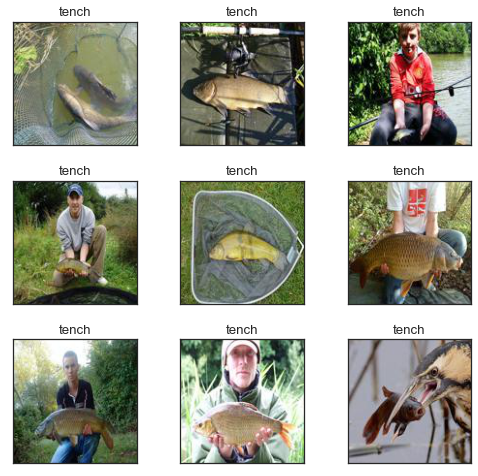

In [7]:
# Display a few train images
train_dataiter = enumerate(trainloader)
_, (train_sample_data, train_sample_targets) = next(train_dataiter)

show_samples(train_sample_data, train_sample_targets)

tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


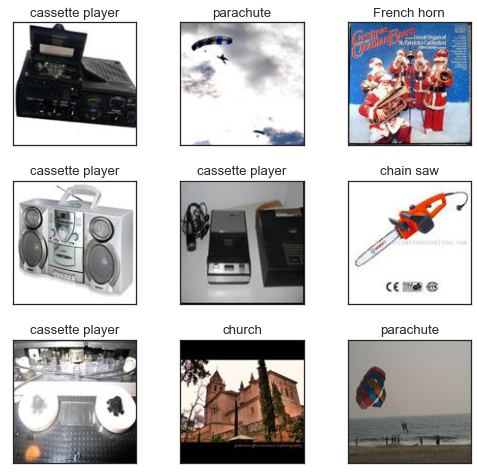

In [8]:
# Display a few test images
test_dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(test_dataiter)

show_samples(test_sample_data, test_sample_targets)

tensor shape: (750, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


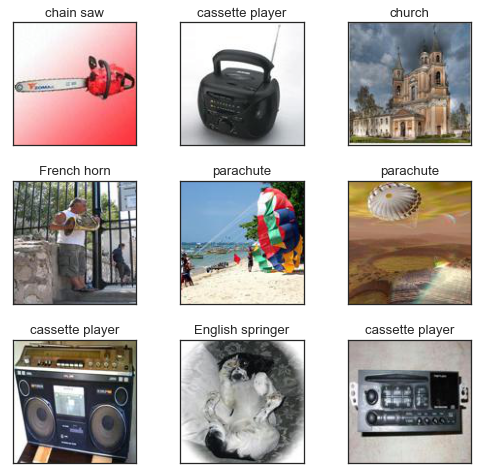

In [9]:
# Display a few calibration images
calib_dataiter = enumerate(calibloader)
_, (calib_sample_data, calib_sample_targets) = next(calib_dataiter)

show_samples(calib_sample_data, calib_sample_targets)

## Prepare Network Architecture

We use the [resnet18](https://arxiv.org/abs/1512.03385) network architecture from the PyTorch package [torchvision](https://pytorch.org/vision/stable/index.html) (see [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)). However, the architecture was built for the [ImageNet dataset](https://www.image-net.org/). Thus, the architecture has an output size of 1000 which correspond to the 1000 [ImageNet](https://www.image-net.org/) classes. However, [Imagenette](https://github.com/fastai/imagenette) only has 10 classes. Thus, we need to adapt the output layer accordingly.

In [10]:
num_ftrs = arch.fc.in_features
arch.fc = nn.Linear(num_ftrs, num_classes)

print(arch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model_parameters = filter(lambda p: p.requires_grad, arch.parameters())
params = sum([np.prod(p.size()) for p in model_parameters]); 

print("Number of model parameters: {}".format(params))

Number of model parameters: 11181642


## Define Test Functions

In [12]:
def test(model, criterion, dataloader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in dataloader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(dataloader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

def test_final(model, dataloader, criterion):
    _, accs = test(model, criterion, dataloader, [], [])
    return accs[0]

## Model Testing

In [13]:
# Create Model
model = arch
criterion = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(
    torch.load(str(model_path)+'.pth', map_location=torch.device('cpu'))
)

<All keys matched successfully>

In [14]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

In [15]:
train_acc = test_final(model, trainloader, criterion)
test_acc = test_final(model, testloader, criterion)
calib_acc = test_final(model, calibloader, criterion)

print('train accuracy: {}'.format(train_acc))
print('test accuracy:  {}'.format(test_acc))
print('calib accuracy: {}'.format(calib_acc))


Test set: Avg. loss: 0.000001, Accuracy: 9468/9469 (99.99%)


Test set: Avg. loss: 0.000845, Accuracy: 2736/3175 (86.17%)


Test set: Avg. loss: 0.000829, Accuracy: 656/750 (87.47%)

train accuracy: 99.98943922272679
test accuracy:  86.1732283464567
calib accuracy: 87.46666666666667


## Choose Layers

__Make sure to choose the desired layers from which to fetch the activations from!__

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
layers = {                                     
    'relu': model.relu,
    'maxpool': model.maxpool,
    'layer1-0': model.layer1[0],
    'layer1-1': model.layer1[1],
    'layer2-0': model.layer2[0],
    'layer2-1': model.layer2[1],
    'layer3-0': model.layer3[0],
    'layer3-1': model.layer3[1],
    'layer4-0': model.layer4[0],
    'layer4-1': model.layer4[1],
    'avgpool': model.avgpool
}

## Define Function for Fetching Activations

The activation tensors that get fetched from a layer could be quite large. This will be the case for the early layers in particular. Thus, we fetch the activations from each separately and store it. Thus, is slower than fetching the activations for each layer at once. However, as the activation tensors could get quite large and the training data contains many samples we might run into memory problems. Hence, we process each layer separately here. 

In [18]:
def fetch_activations(dataloader, model, layers, dataset_name):    
    targets = None

    for layer_name in layers:
        print('## Fetching Activations from Layer {}'.format(layer_name))

        # Fetch activations for the data
        layer = layers[layer_name]
        layer_activations, layer_targets = fetch_activations_from_layer(dataloader, model, layer)
        print('- activations fetched: {}'.format(layer_activations.shape))
        
        # Check the targets of that data
        if layer_targets is not None:
            if targets is not None:
                np.testing.assert_array_equal(targets, layer_targets)
            else:
                targets = layer_targets

        # Save activations
        activations = {}
        activations['activations'] = layer_activations
        activations['targets'] = layer_targets
        
        fname = str(acts_path) + '_{}_{}.pkl'.format(dataset_name, layer_name)
        with open(fname, 'wb') as pickle_file:
            pickle.dump(activations, pickle_file, protocol=4)


        print("done!")        
        print()      
        
def fetch_activations_from_layer(dataloader, model, layer):
    activations = []
    targets = []

    # Define hook for fetching the activations
    def hook(module, input, output):
        layer_activations = output.squeeze().detach().cpu()
        activations.append(layer_activations)

    handle = layer.register_forward_hook(hook)

    # Fetch activations
    for i, batch in enumerate(dataloader):
        print('Processing Batch {}'.format(i))

        if use_cuda:
            batch = batch.cuda()
            
        _ = model(batch[0])

        if len(batch) > 1:
            targets.append(batch[1].detach().cpu().numpy())

    # Remove hook
    handle.remove()

    # Return activations and targets
    activations = np.concatenate(activations)

    if targets:
        targets = np.hstack(targets)
    else:
        None

    return activations, targets

## Fetch Activations from Training Set

In [19]:
trainset_name = 'trainset'
fetch_activations(trainloader, model, layers, trainset_name)

## Fetching Activations from Layer relu
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
- activations fetched: (9469, 64, 64, 64)
done!

## Fetching Activations from Layer maxpool
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
- activations fetched: (9469, 64, 32, 32)
done!

## Fetching Activations from Layer layer1-0
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
- activations fetched: (9469, 64, 32, 32)
done!

## Fetching Activations from Layer layer1-1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 

In [20]:
for layer_name in layers:
    fname = str(acts_path) + '_{}_{}.pkl'.format(trainset_name, layer_name)
    with open(fname, 'rb') as pickle_file:
        loaded_activations = pickle.load(pickle_file)
    
    print('## layer {}'.format(layer_name))
    print('activations: {}, targets: {}'.format(
        loaded_activations['activations'].shape, loaded_activations['targets'].shape
    ))
    print()

## layer relu
activations: (9469, 64, 64, 64), targets: (9469,)

## layer maxpool
activations: (9469, 64, 32, 32), targets: (9469,)

## layer layer1-0
activations: (9469, 64, 32, 32), targets: (9469,)

## layer layer1-1
activations: (9469, 64, 32, 32), targets: (9469,)

## layer layer2-0
activations: (9469, 128, 16, 16), targets: (9469,)

## layer layer2-1
activations: (9469, 128, 16, 16), targets: (9469,)

## layer layer3-0
activations: (9469, 256, 8, 8), targets: (9469,)

## layer layer3-1
activations: (9469, 256, 8, 8), targets: (9469,)

## layer layer4-0
activations: (9469, 512, 4, 4), targets: (9469,)

## layer layer4-1
activations: (9469, 512, 4, 4), targets: (9469,)

## layer avgpool
activations: (9469, 512), targets: (9469,)



## Fetch Activations from Calibration Set

In [21]:
calibset_name = 'calibset'
fetch_activations(calibloader, model, layers, calibset_name)

## Fetching Activations from Layer relu
Processing Batch 0
- activations fetched: (750, 64, 64, 64)
done!

## Fetching Activations from Layer maxpool
Processing Batch 0
- activations fetched: (750, 64, 32, 32)
done!

## Fetching Activations from Layer layer1-0
Processing Batch 0
- activations fetched: (750, 64, 32, 32)
done!

## Fetching Activations from Layer layer1-1
Processing Batch 0
- activations fetched: (750, 64, 32, 32)
done!

## Fetching Activations from Layer layer2-0
Processing Batch 0
- activations fetched: (750, 128, 16, 16)
done!

## Fetching Activations from Layer layer2-1
Processing Batch 0
- activations fetched: (750, 128, 16, 16)
done!

## Fetching Activations from Layer layer3-0
Processing Batch 0
- activations fetched: (750, 256, 8, 8)
done!

## Fetching Activations from Layer layer3-1
Processing Batch 0
- activations fetched: (750, 256, 8, 8)
done!

## Fetching Activations from Layer layer4-0
Processing Batch 0
- activations fetched: (750, 512, 4, 4)
done!

## Fetc

In [22]:
for layer_name in layers:
    fname = str(acts_path) + '_{}_{}.pkl'.format(calibset_name, layer_name)
    with open(fname, 'rb') as pickle_file:
        loaded_activations = pickle.load(pickle_file)
    
    print('## layer {}'.format(layer_name))
    print('activations: {}, targets: {}'.format(
        loaded_activations['activations'].shape, loaded_activations['targets'].shape
    ))
    print()

## layer relu
activations: (750, 64, 64, 64), targets: (750,)

## layer maxpool
activations: (750, 64, 32, 32), targets: (750,)

## layer layer1-0
activations: (750, 64, 32, 32), targets: (750,)

## layer layer1-1
activations: (750, 64, 32, 32), targets: (750,)

## layer layer2-0
activations: (750, 128, 16, 16), targets: (750,)

## layer layer2-1
activations: (750, 128, 16, 16), targets: (750,)

## layer layer3-0
activations: (750, 256, 8, 8), targets: (750,)

## layer layer3-1
activations: (750, 256, 8, 8), targets: (750,)

## layer layer4-0
activations: (750, 512, 4, 4), targets: (750,)

## layer layer4-1
activations: (750, 512, 4, 4), targets: (750,)

## layer avgpool
activations: (750, 512), targets: (750,)

